# Smoking (chapter 5)

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

Authors: <b>Aymen Merrouche</b> and Pierre-Henri Wuillemin.

**This notebook follows the example from "The Book Of Why" (Pearl, 2018) chapter 5**

In [1]:
from IPython.display import display, Math, Latex,HTML

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb
import os

> In the 1950s the strong association between smoking and lung cancer provoked a debate on the issue. Does smoking cause lung cancer?

### Corresponding causal diagram:
The corresponding causal diagram is the following:

In [2]:
sc = gum.fastBN("Smoking->Lung Cancer")
sc

(pyAgrum.BayesNet<double>@0x559598a64680) BN{nodes: 2, arcs: 1, domainSize: 4, dim: 3, mem: 48o}

### Constitutional Hypothesis:
> Smoking industry and some other skeptic statisticians advanced the theory that smokers are genetically different from nonsmokers. A smoking gene could be a confounder that would explain the observed association.

In [3]:
msc = csl.CausalModel(sc, [("Smoking Gene", ["Smoking","Lung Cancer"])])
cslnb.showCausalImpact(msc, "Lung Cancer", doing="Smoking",values={})

> This constitutional hypothesis was untestable, we couldn't sequence the human genome at the time. <br>
However, this hypothesis wasn't plausible because the observed association was way too strong. <br>

### Another explanation 
To explain this association, another hypothesis was that a smoking gene could be a confounder but there was still a direct causal effect between smoking on lung cancer:

In [4]:
msc = csl.CausalModel(sc, [("Smoking Gene", ["Smoking","Lung Cancer"])], True)
cslnb.showCausalImpact(msc, "Lung Cancer", doing="Smoking",values={})

### Front door criterion:

> Let's suppose now that smoking causes cancer only through tar deposits that are fully due to the physical action of cigarettes, the causal diagram becomes:

In [5]:
sct = gum.fastBN("Smoking->Tar->Lung Cancer")
sct

(pyAgrum.BayesNet<double>@0x559599cbddc0) BN{nodes: 3, arcs: 2, domainSize: 8, dim: 5, mem: 80o}

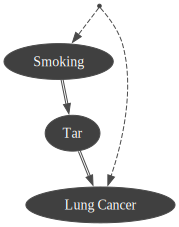

In [6]:
msct = csl.CausalModel(sct, [("Smoking Gene", ["Smoking","Lung Cancer"])], True)
gnb.show(msct)

In [7]:
cslnb.showCausalImpact(msct, "Lung Cancer", doing="Smoking",values={})

> Even if the smoking gene is unobservable, we can assess the causal effect of Smoking on Lung Cancer using the front-door method. In this case, the front-door is: $$Smoking \rightarrow \color{red}{Tar} \rightarrow LungCancer$$
It consists of variables that we have observed:

* We can measure the causal effect of $Smoking$ on $Tar$, there are no open back-doors between the two ($Tar \leftarrow  Smoking \rightarrow SmokingGene \leftarrow LungCancer$ is blocked by the collider node $LungCancer$)
$$P(Tar \mid do(Smoking)) = P (Tar \mid Smoking) $$

In [8]:
formula, adj, exp = csl.causalImpact(msct,on = "Tar",doing = "Smoking",values = {})
display(Math(formula.toLatex()))

<IPython.core.display.Math object>

* We can measure the causal effect of $Tar$ on $LungCancer$, we just need to adjust for the $Smoking$  to block the "back-door path" $ Tar \leftarrow Smoking \leftarrow SmokingGene \rightarrow LungCancer$
$$P(LungCancer \mid do(Tar)) = \sum_{Smoking}{P(LungCancer \mid Tar, Smoking) \times P(Smoking)}$$

In [9]:
formula, adj, exp = csl.causalImpact(msct,on = "Lung Cancer",doing = "Tar",values = {})
display(Math(formula.toLatex()))

<IPython.core.display.Math object>

We can now combine these two pieces of information to have the causal effect of $Smoking$ on $LungCancer$ and reduce the expression of $P(LungCancer \mid do(Smoking))$ to elements that we observed:
$$ P(LungCancer \mid do(Smoking)) = \sum_{Tar}{(P(Tar \mid Smoking) \times \sum_{Smoking^{'}}{P(LungCancer \mid Tar, Smoking^{'}) \times P(Smoking^{'})})} $$

## Birth-weight paradox:

> Studies have shown that babies of smoking mothers tend to weigh less than average. Other studies have shown that low-birth-weight babies have a higher mortality rate than normal-birth-weight babies. The corresponding causal diagram is the following causal:

In [10]:
bwp = gum.fastBN("Smoking->Low Birth Weight->Mortality")
bwp

(pyAgrum.BayesNet<double>@0x559599bc2730) BN{nodes: 3, arcs: 2, domainSize: 8, dim: 5, mem: 80o}

In [11]:
# Causal effect of Smoking on neo-natal mortality
bwpModele = csl.CausalModel(bwp)
cslnb.showCausalImpact(bwpModele, "Mortality", doing="Smoking",values={})

> However the data also showed that low-birth-weight babies of smoker mothers had lower mortality rates than low-birth-weight babies of non-smoker mothers. <br>
An explanation for this paradoxical situation is that low-birth-weight is either due to a smoking mother or to another birth defect that is much more threatening to the baby's health. The causal diagram becomes:

In [12]:
bwpe = gum.fastBN("Smoking->Low Birth Weight->Mortality<-Smoking;Birth defect->Low Birth Weight;Mortality<-Birth defect")
bwpe

(pyAgrum.BayesNet<double>@0x559599be7610) BN{nodes: 4, arcs: 5, domainSize: 16, dim: 14, mem: 224o}

> Pinpointing the source of this paradoxical situation becomes easy thanks to this causal diagram: "collider bias"."Low Birth Weight" is a collider! 
The data only concerned low-birth-weight babies (it is as if we are adjusting for "Low Birth Weight."). Knowing that the mother doesn't smoke increases our belief that a birth defect is the cause of the low-birth-weight, and a birth defect is more threatening for the baby's health. This opened the backdoor path formerly blocked and allowed non-causal information to flow from Smoking to Mortality ($Smoking \rightarrow Low Birth Weight \leftarrow Birth defect \rightarrow Mortality $) introducing a bias.

In [13]:
bwpeModele = csl.CausalModel(bwpe)
cslnb.showCausalImpact(bwpeModele, "Mortality", doing="Smoking",values={})